## Does Amharic Plus Perform better?


We're just looking for performance better than 68% so maybe adding more languages in encourages some transfer learning. Let's add the other languages in and see if there's performance improvements.

In [4]:
# Import tfds and tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd

### 1.1. Load OLID data and Amharic Data

We're going to load everything upfront so that we have it all more or less ready. The OLID data is English (by far the largest), Turkish, Danish, Greek, Arabic, and an extra dataset with Amharic.

In [5]:
#load our tuned Amharic dataset
amharic_data = pd.read_csv('data/Amharic/amharic.csv')
amharic_train, amharic_test = train_test_split(amharic_data)

In [3]:
amharic_train.head()

,id,tweet,subtask_a
23936,23936,አንድ ማወቅ ያለብን ነገር እሱም ስራውም ዋጋ ያስከፍላል እንጂ ማንኛውም ...,NOT
27421,27421,አገራችን ላይ ለመኖር ዋስትና አጣን,NOT
13280,13280,አዳሜ እዉነት እየመሰለዉ ሊንኩን ይከፍታል,OFF
9621,9621,አዋጭ እና ዘላቂ የሆነ ለህዝቡ ሚጠቅም ሀሳብ ሀሳብ ሲቀርብልን ስለ ሀሳቡ...,NOT
9398,9398,በዚህ ሂደት በወልቃይት ጠገዴ የሰፈሩት የትግራይ ተወላጆቸ የመፈናቀል ወይ...,NOT


In [6]:
#load all our OLID datasets
danish = pd.read_csv('data/Danish/train.tsv', delimiter='\t')
turkish = pd.read_csv('data/Turkish/train.tsv', delimiter='\t')
greek = pd.read_csv('data/Greek/train.tsv', delimiter='\t')
arabic = pd.read_csv('data/Arabic/train.tsv', delimiter='\t')

In [32]:
#load all our OLID datasets
danish_test = pd.read_csv('data/Danish/test.tsv', delimiter='\t')
turkish_test = pd.read_csv('data/Turkish/test.tsv', delimiter='\t')
greek_test = pd.read_csv('data/Greek/test.tsv', delimiter='\t')
arabic_test = pd.read_csv('data/Arabic/test.tsv', delimiter='\t')

In [7]:
MODEL_TYPE = 'xlm-roberta-base'


L_RATE = 1e-5 # need to change this potentially
MAX_LEN = 256

NUM_EPOCHS = 3
BATCH_SIZE = 32


In [8]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

# xlm-roberta-large
print('Loading XLMRoberta tokenizer...')
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)
print('Tokenizer loaded')

Loading XLMRoberta tokenizer...
Tokenizer loaded


In [10]:
import torch

MAX_LEN = 256 # This value could be set as 256, 512 etc.

def create_tensors( all_training_sets ):
    
    _all_labels = []
    _all_input_ids = []
    _all_attn_masks = []
    
    for t_set in all_training_sets:
        new_ids, new_masks, new_labels = tokenize_dataset(t_set)
        _all_input_ids = [*_all_input_ids, *new_ids]
        _all_attn_masks = [*_all_attn_masks, *new_masks]
        _all_labels = [*_all_labels, *new_labels]
        
    # Convert each Python list of Tensors into a 2D Tensor matrix.
    _all_input_ids = torch.cat(_all_input_ids, dim=0)
    _all_attn_masks = torch.cat(_all_attn_masks, dim=0)

    # Cast the labels list to a Tensor.
    _all_labels_tensor = torch.tensor(_all_labels)
    
    return _all_input_ids, _all_attn_masks, _all_labels_tensor, _all_labels

def tokenize_dataset( training_set ):
    
    _labels = []
    _ids = []
    _masks = []
    
    # look through all records
    for index, row in training_set.iterrows():
        encoded_dict = tokenizer.encode_plus(
                    row['tweet'], # Sentence to encode.
                    add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                    max_length = MAX_LEN,           # Pad or truncate.
                    pad_to_max_length = True,
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt',          # Return pytorch tensors.
                   )

        # Add this example to our lists.
        _ids.append(encoded_dict['input_ids'])
        _masks.append(encoded_dict['attention_mask'])
        if(row['subtask_a'] == 'NOT'):
            _labels.append(0)
        else:
            _labels.append(1)
    
    return _ids, _masks, _labels

datasets = [amharic_train, danish, turkish, greek, arabic]
all_input_ids, all_attn_masks, all_labels_tensor, all_labels = create_tensors(datasets)


print('   DONE. {:,} examples.'.format(len(all_labels)))

   DONE. 65,105 examples.


/home/joshnoble/.local/share/virtualenvs/joshnoble-TX97Gyyd/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


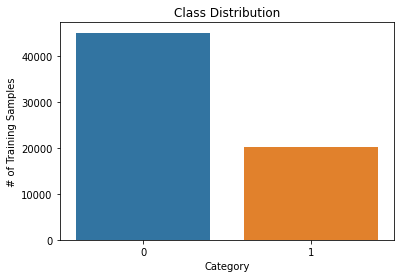

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot the number of tokens of each length.
sns.countplot(all_labels)

plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')

plt.show()

In [12]:

test_labels_amharic = []
test_input_ids_amharic = []
test_attn_masks_amharic = []

# look through all records
for index, row in amharic_test.iterrows():
    encoded_dict = tokenizer.encode_plus(
                row['tweet'], # Sentence to encode.
                add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                max_length = MAX_LEN,           # Pad or truncate.
                pad_to_max_length = True,
                return_attention_mask = True,   # Construct attn. masks.
                return_tensors = 'pt',          # Return pytorch tensors.
               )

    # Add this example to our lists.
    test_input_ids_amharic.append(encoded_dict['input_ids'])
    test_attn_masks_amharic.append(encoded_dict['attention_mask'])
    if(row['subtask_a'] == 'NOT'):
        test_labels_amharic.append(0)
    else:
        test_labels_amharic.append(1)
    
    
# Convert each Python list of Tensors into a 2D Tensor matrix.
test_input_ids_amharic = torch.cat(test_input_ids_amharic, dim=0)
test_attn_masks_amharic = torch.cat(test_attn_masks_amharic, dim=0)

# Cast the labels list to a Tensor.
test_labels_amharic_tensor = torch.tensor(test_labels_amharic)

print('   DONE. {:,} examples.'.format(len(test_labels_amharic)))

/home/joshnoble/.local/share/virtualenvs/joshnoble-TX97Gyyd/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2105: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   DONE. 7,500 examples.


In [34]:

test_labels_turkish = []
test_input_ids_turkish = []
test_attn_masks_turkish = []

# look through all records
for index, row in turkish_test.iterrows():
    encoded_dict = tokenizer.encode_plus(
                row['tweet'], # Sentence to encode.
                add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                max_length = MAX_LEN,           # Pad or truncate.
                pad_to_max_length = True,
                return_attention_mask = True,   # Construct attn. masks.
                return_tensors = 'pt',          # Return pytorch tensors.
               )

    # Add this example to our lists.
    test_input_ids_turkish.append(encoded_dict['input_ids'])
    test_attn_masks_turkish.append(encoded_dict['attention_mask'])
    if(row['subtask_a'] == 'NOT'):
        test_labels_turkish.append(0)
    else:
        test_labels_turkish.append(1)
    
    
# Convert each Python list of Tensors into a 2D Tensor matrix.
test_input_ids_turkish = torch.cat(test_input_ids_turkish, dim=0)
test_attn_masks_turkish = torch.cat(test_attn_masks_turkish, dim=0)

# Cast the labels list to a Tensor.
test_labels_turkish_tensor = torch.tensor(test_labels_turkish)

print('   DONE. {:,} examples.'.format(len(test_labels_turkish)))

   DONE. 3,528 examples.


In [14]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Specify our batch size.
batch_size = 16

# Construct a TensorDataset from the encoded examples.
prediction_dataset = TensorDataset(test_input_ids_amharic, test_attn_masks_amharic, test_labels_amharic_tensor)

# And a dataloader for handling batching.
prediction_dataloader = DataLoader(prediction_dataset, batch_size=batch_size)

In [35]:
# Construct a TensorDataset from the encoded examples.
prediction_dataset_turkish = TensorDataset(test_input_ids_turkish, test_attn_masks_turkish, test_labels_turkish_tensor)

# And a dataloader for handling batching.
prediction_dataloader_turkish = DataLoader(prediction_dataset_turkish, batch_size=batch_size)

In [15]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(all_input_ids, all_attn_masks, all_labels_tensor)

# Create a 90-10 train-validation split. Calculate the number of samples to 
# include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Specify our batch size.
batch_size = 16

# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )




## Some Helper Functions

* **format_time** - Converts floating point seconds into hh:mm:ss
* **good_update_interval** - For printing updates, this will choose an interval.
* **check_gpu_mem** - Reports how much of the GPU's memory we're using.

Helper function for formatting elapsed times.

In [16]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Helper function to automatically pick a reasonable interval for printing out a progress update during training.

In [17]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

## Get the model

We'll load the 'large' model. We could also use the base model (or any other version) but this one should be good to start.

In [18]:
from transformers import XLMRobertaForSequenceClassification
import torch
import gc

if 'xlmr_model' in globals():
    del xlmr_model
    gc.collect()
    torch.cuda.empty_cache()

# we're going 2 labels: offensive and not
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels=2)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Now load the model to the GPU

In [19]:
print('Loading model to GPU...')

# Connect to the GPU.
device = torch.device('cuda')

# Report what GPU we were granted.
print('  GPU:', torch.cuda.get_device_name(0))

# Copy the initial model weights to the GPU.
desc = xlmr_model.to(device)

print('    DONE.')

Loading model to GPU...
  GPU: Tesla K80
    DONE.


In [20]:
torch.cuda.memory_summary(device=None, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1060 MB |    1060 MB |    1060 MB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |    1060 MB |    1060 MB |    1060 MB |       0 B  |\n|---------------------------------------------------------------------------|\n| GPU reserved memory   |    1116 MB |    1116 MB |    1116 MB |       0 B  |\n|--------------------------------------------------

## Now it's time to train with our Amharic labels

In [21]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(xlmr_model.parameters(),
                  lr = 5e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [18]:
# import torch
# torch.cuda.empty_cache()

# check_gpu_mem()

In [22]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    xlmr_model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader), 
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #
        # Even though this is a two sentence task, XLM-R does not appear to
        # require an explicit "Segment ID" mask.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        xlmr_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        loss, logits = xlmr_model.forward(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels, return_dict=False)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(xlmr_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
 
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    xlmr_model.eval()

    # Tracking variables 
    total_eval_loss = 0


    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = xlmr_model.forward(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # For each sample, pick the label (0, 1, or 2) with the highest score.
    predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

    # Calculate the validation accuracy.
    val_accuracy = (predicted_labels == flat_true_labels).mean()

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch   400  of  3,663.    Elapsed: 0:09:09.
  Batch   800  of  3,663.    Elapsed: 0:18:20.
  Batch 1,200  of  3,663.    Elapsed: 0:27:32.
  Batch 1,600  of  3,663.    Elapsed: 0:36:44.
  Batch 2,000  of  3,663.    Elapsed: 0:45:56.
  Batch 2,400  of  3,663.    Elapsed: 0:55:08.
  Batch 2,800  of  3,663.    Elapsed: 1:04:20.
  Batch 3,200  of  3,663.    Elapsed: 1:13:32.
  Batch 3,600  of  3,663.    Elapsed: 1:22:45.

  Average training loss: 0.50
  Training epcoh took: 1:24:11

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.45
  Validation took: 0:03:05

======== Epoch 2 / 3 ========
Training...
  Batch   400  of  3,663.    Elapsed: 0:09:12.
  Batch   800  of  3,663.    Elapsed: 0:18:24.
  Batch 1,200  of  3,663.    Elapsed: 0:27:36.
  Batch 1,600  of  3,663.    Elapsed: 0:36:48.
  Batch 2,000  of  3,663.    Elapsed: 0:46:00.
  Batch 2,400  of  3,663.    Elapsed: 0:55:12.
  Batch 2,800  of  3,663.    Elapsed: 1:04:25.
  Batch 3

Let's view the summary of the training process.

First we'll put the statistics into a pandas DataFrame.

In [23]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.50,0.45,0.77,1:24:11,0:03:05
2,0.43,0.43,0.79,1:24:15,0:03:05
3,0.40,0.44,0.80,1:24:15,0:03:05


Now let's plot the 'learning curve'.

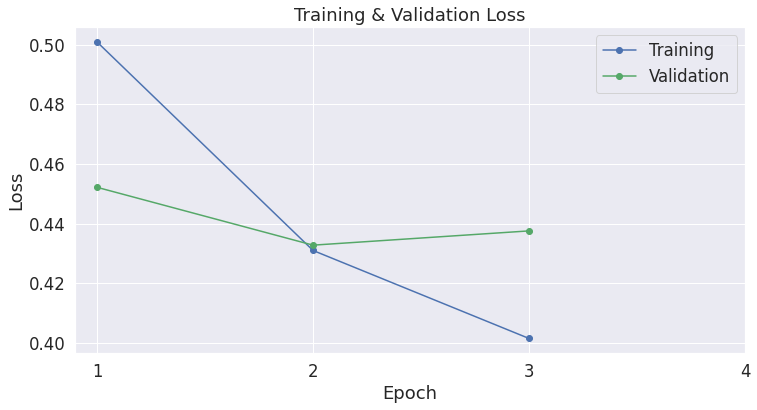

In [24]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Looks like we overfit some on the third epoch.

To counteract this, you could try running validation more often (i.e., multiple times during each epoch), and break the training loop as soon as the validation loss increases.

## 4.2. Run Prediction

Run all of our Amharic test samples through our model to get predictions!

In [39]:
# Prediction on test set
print('Predicting labels for {:,} test examples...'.format(len(test_labels_amharic)))

# Put model in evaluation mode
xlmr_model.eval()

# Tracking variables 
predictions , true_labels = [], []

count = 0

# Predict 
for batch in prediction_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = xlmr_model(b_input_ids, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 7,500 test examples...
    DONE.


In [45]:
# Prediction on test set
print('Predicting labels for {:,} test examples...'.format(len(test_labels_turkish)))

# Put model in evaluation mode
xlmr_model.eval()

# Tracking variables 
predictions_turkish , true_labels_turkish = [], []

count = 0

# Predict 
for batch in prediction_dataloader_turkish:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = xlmr_model(b_input_ids, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions_turkish.append(logits)
    true_labels_turkish.append(label_ids)

print('    DONE.')

Predicting labels for 3,528 test examples...
    DONE.


To turn our model outputs into actual predictions, we need to:

1. Re-combine the predictions from across all of the batches.
2. Pick a class label for each prediction by choosing the class with the highest output value.

In [40]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# For each sample, pick the label (0, 1) with the highest score.
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

Now we can measure our accuracy...

In [41]:
# Tally the number of correct predictions to get our accuracy.
accuracy = (predicted_labels == flat_true_labels).mean()

print('XLM-R Prediction accuracy for amharic: {:.3f}'.format(accuracy))

XLM-R Prediction accuracy: 0.647


In [48]:
# Combine the results across all batches. 
flat_predictions_tr = np.concatenate(predictions_turkish, axis=0)
flat_true_labels_tr = np.concatenate(true_labels_turkish, axis=0)

# For each sample, pick the label (0, 1) with the highest score.
predicted_labels_turkish = np.argmax(flat_predictions_tr, axis=1).flatten()

accuracy = (predicted_labels_turkish == flat_true_labels_tr).mean()

print('XLM-R Prediction accuracy for turkish: {:.3f}'.format(accuracy))

XLM-R Prediction accuracy: 0.868
